In [1]:
import sys
sys.stdout = open('prints.txt', 'w')
from utils import save_path_generator, get_all_info, visualize, visualize_interact, wave_transform, detector_image, save_path_generator
from ganrec2 import tfnor_phase, GANphase, ssim_check, psnr_check
import tensorflow as tf
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from skimage import io as io
import numpy as np

2023-06-19 15:23:13.493185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Running GANPhase for two datas

> #### <u> 1. Projection of phantom object at P05 - 18 KEV </u>

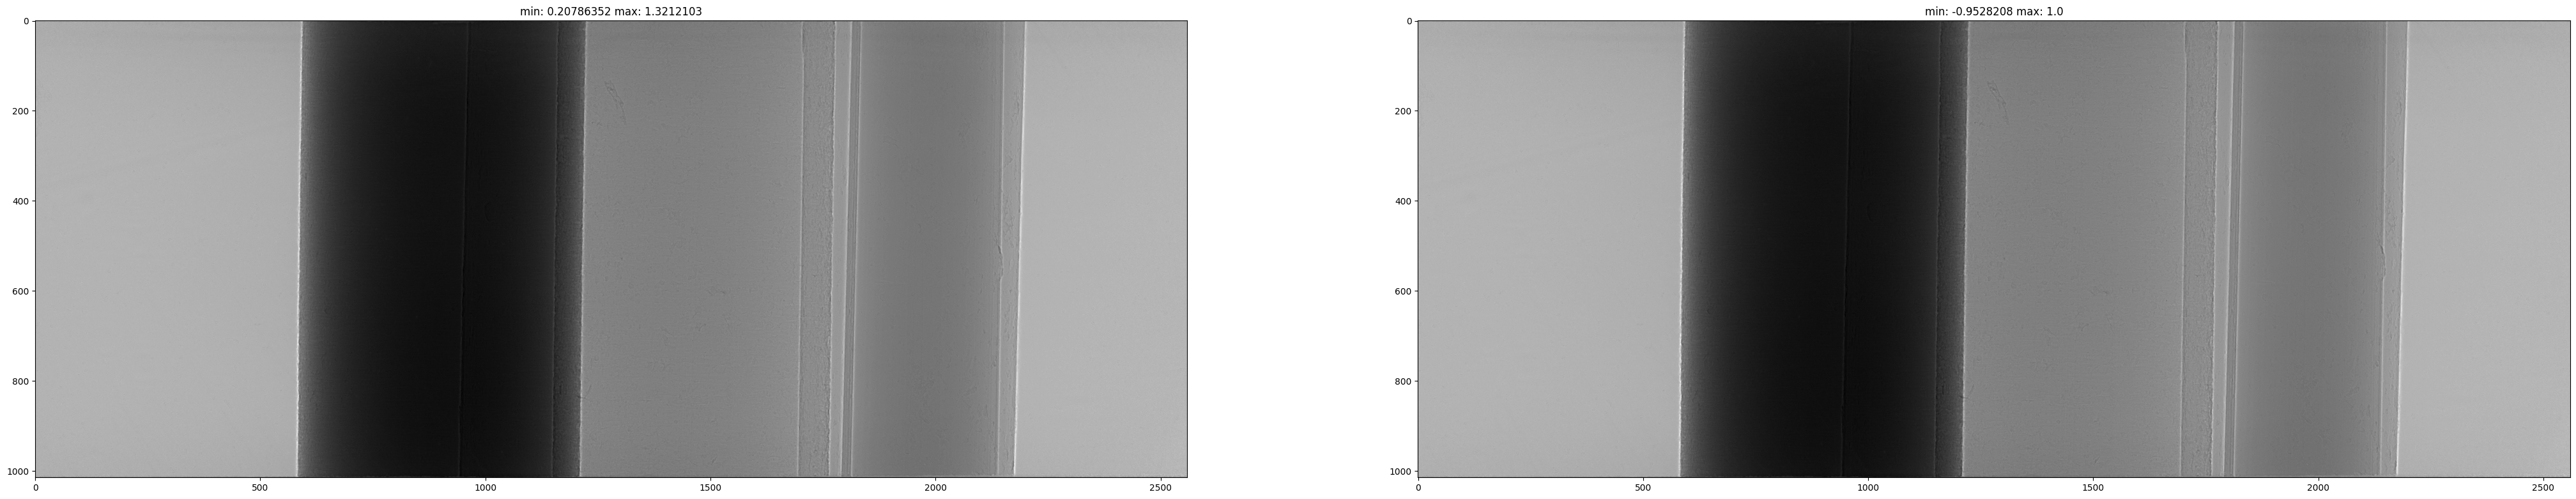

In [23]:
path = "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2"
pad = 4.97766
idx = 89
images = io.imread_collection(path + '/*.tif')
kwargs = get_all_info(path = path, idx = idx, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None)


energy = kwargs["energy_kev"]
lam = kwargs["lam"]
z = kwargs["distance_sample_detector"]
pv = kwargs["detector_pixel_size"]
px = kwargs["shape_x"]
py = kwargs["shape_y"]
image = kwargs["image"]

data = tfnor_phase(tf.reshape(image, [1, px, py, 1]))[0,:,:,0]

kwargs["i_input"] = data
kwargs["z"] = kwargs["distance_sample_detector"]
kwargs["lam"] = kwargs["lam"]
kwargs["pv"] = kwargs["detector_pixel_size"]
print("******************************\n \tThe input is image with shape {}".format(image.shape), "at energy {} kev".format(energy), "with pixel size {} m".format(pv), "and distance {} m".format(z), "min/max of image" , np.min(image), np.max(image), "\n******************************")
visualize([image, data])


2023-06-19 15:24:02.083667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-19 15:24:02.170867: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz
2023-06-19 15:24:03.259926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-19 15:24:04.168634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-19 15:24:10.653753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10


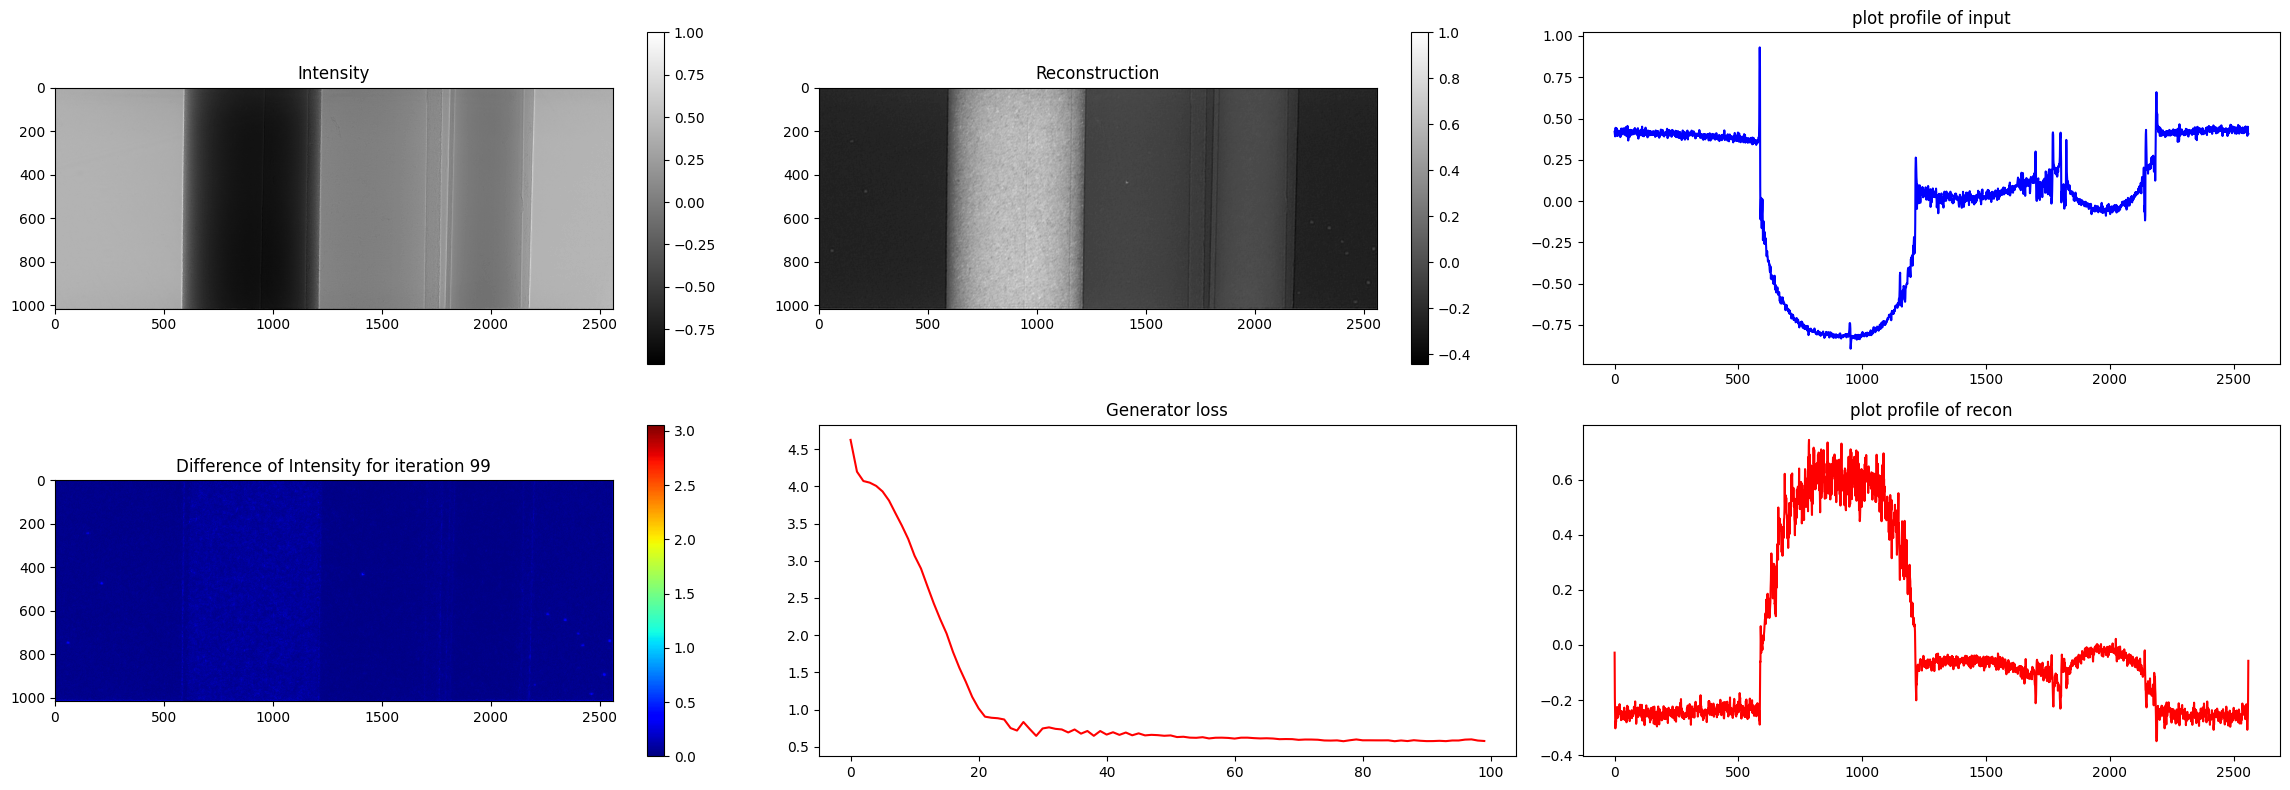

In [7]:
kwargs["iter_num"] = 1000
kwargs.update(save_path_generator(**kwargs))
# display(kwargs)
kwargs["init_model"] = False
# kwargs["save_wpath"] = None  ## if you want to save the model, please set the path
print(kwargs['save_wpath'], '\n', kwargs['init_wpath'], '\n', kwargs['file_name'])

gan_phase_object_phantom = GANphase(**kwargs)

start = time.time()
rec_phantom = gan_phase_object_phantom.recon
end = time.time()
print('Running time is {}'.format(end - start))


Final reconstruction and ssim check

In [8]:
#SSIM between the input image and the lib.detected_image(rec_phantom[1], rec_phantom[0])
from ganrec2 import FresnelPropagator
ff = fresnel_operator(gan_phase_object_phantom.px, gan_phase_object_phantom.py, gan_phase_object_phantom.pv, gan_phase_object_phantom.z, gan_phase_object_phantom.energy)
def ssim_check(image, rec_phantom, ff):
    propagated = FresnelPropagator(rec_phantom[1], rec_phantom[0], ff, z)
    data_im = tfnor_phase(tf.reshape(image, [1, px, py, 1]))
    ssim = tf.image.ssim(data_im, propagated, max_val = 1.0)
    visualize_interact([propagated[0,:,:,0], data_im[0,:,:,0]])
    print("SSIM between the input image and the reconstructed image is {}".format(ssim))
    return ssim
ssim_check(data, rec_phantom, ff)



interactive(children=(Dropdown(description='Show or plot:', options=('show', 'plot'), value='show'), IntSlider…

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.66330504], dtype=float32)>

In [9]:
#Noise to signal ratio
def peak_signal_to_noise(image, rec_phantom, ff, z):
    propagated = FresnelPropagator(rec_phantom[1], rec_phantom[0], ff, z)
    data_im = tfnor_phase(tf.reshape(image, [1, px, py, 1]))
    ssim = tf.image.ssim(data_im, propagated, max_val = 1.0)
    # visualize_interact([propagated[0,:,:,0], data_im[0,:,:,0]])
    psnr = tf.image.psnr(data_im, propagated, max_val = 1.0)
    print("Noise to signal ratio is {}".format(psnr))
    return psnr
peak_signal_to_noise(image, rec_phantom, ff, kwargs['distance'])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([24.839722], dtype=float32)>

### what if we use the model to predict an other projection

In [12]:
#use the trained model to retrieve the phase of another
idx = 1000
image2 = io.imread(images.files[idx])
data2 = tfnor_phase(tf.reshape(image2, [1, px, py, 1]))[0,:,:,0]
rec2= gan_phase_object_phantom.generator(tf.reshape(data2, [1, px, py, 1]))
phase2 = tfnor_phase(rec2[:, :, :, 0]) 
absorption2 = tfnor_phase(rec2[:, :, :, 1])
ssim_check(data2, [absorption2[0], phase2[0]], ff)

interactive(children=(Dropdown(description='Show or plot:', options=('show', 'plot'), value='show'), IntSlider…

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.11779243], dtype=float32)>

> <b> We see that the prediction is not a good one </b> 


> <b> We notice an overfitting and not adopted to the new image </b>

#### Retraining with loaded genator

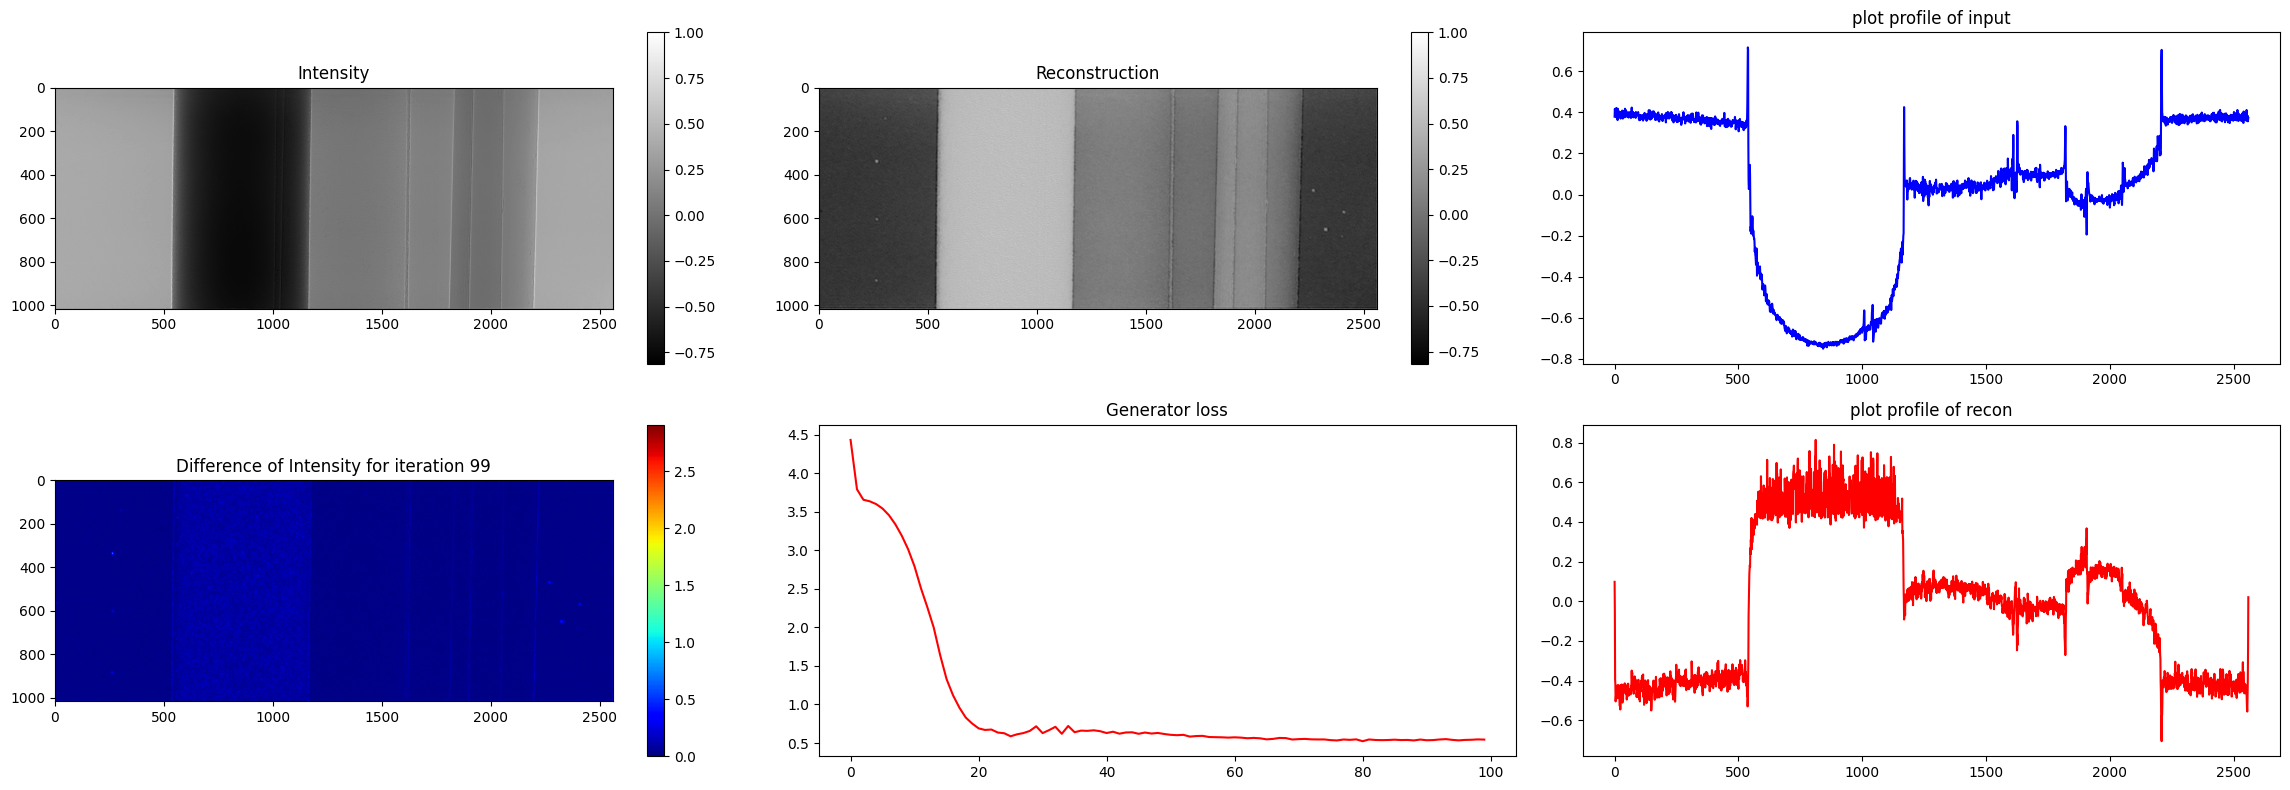

In [16]:
# kwargs.update(save_path_generator(**kwargs))
idx = 10
image2 = io.imread(images.files[idx])
data2 = tfnor_phase(tf.reshape(image2, [1, px, py, 1]))[0,:,:,0]
kwargs["i_input"] = data2
kwargs["save_wpath"] = None
kwargs["init_wpath"] = False
kwargs["file_name"] = images.files[idx].split("/")[-1].split(".")[0]
kwargs["iter_num"] = 100
gan_phase_object_phantom = GANphase(**kwargs)
start_time = time.time()
rec2 = gan_phase_object_phantom.recon
total_time = time.time() - start_time
print("Running time is {}".format(total_time))



In [17]:
ssim_check(data2, rec2, ff)

interactive(children=(Dropdown(description='Show or plot:', options=('show', 'plot'), value='show'), IntSlider…

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.4052531], dtype=float32)>

# Prediction after only few iterations in the end

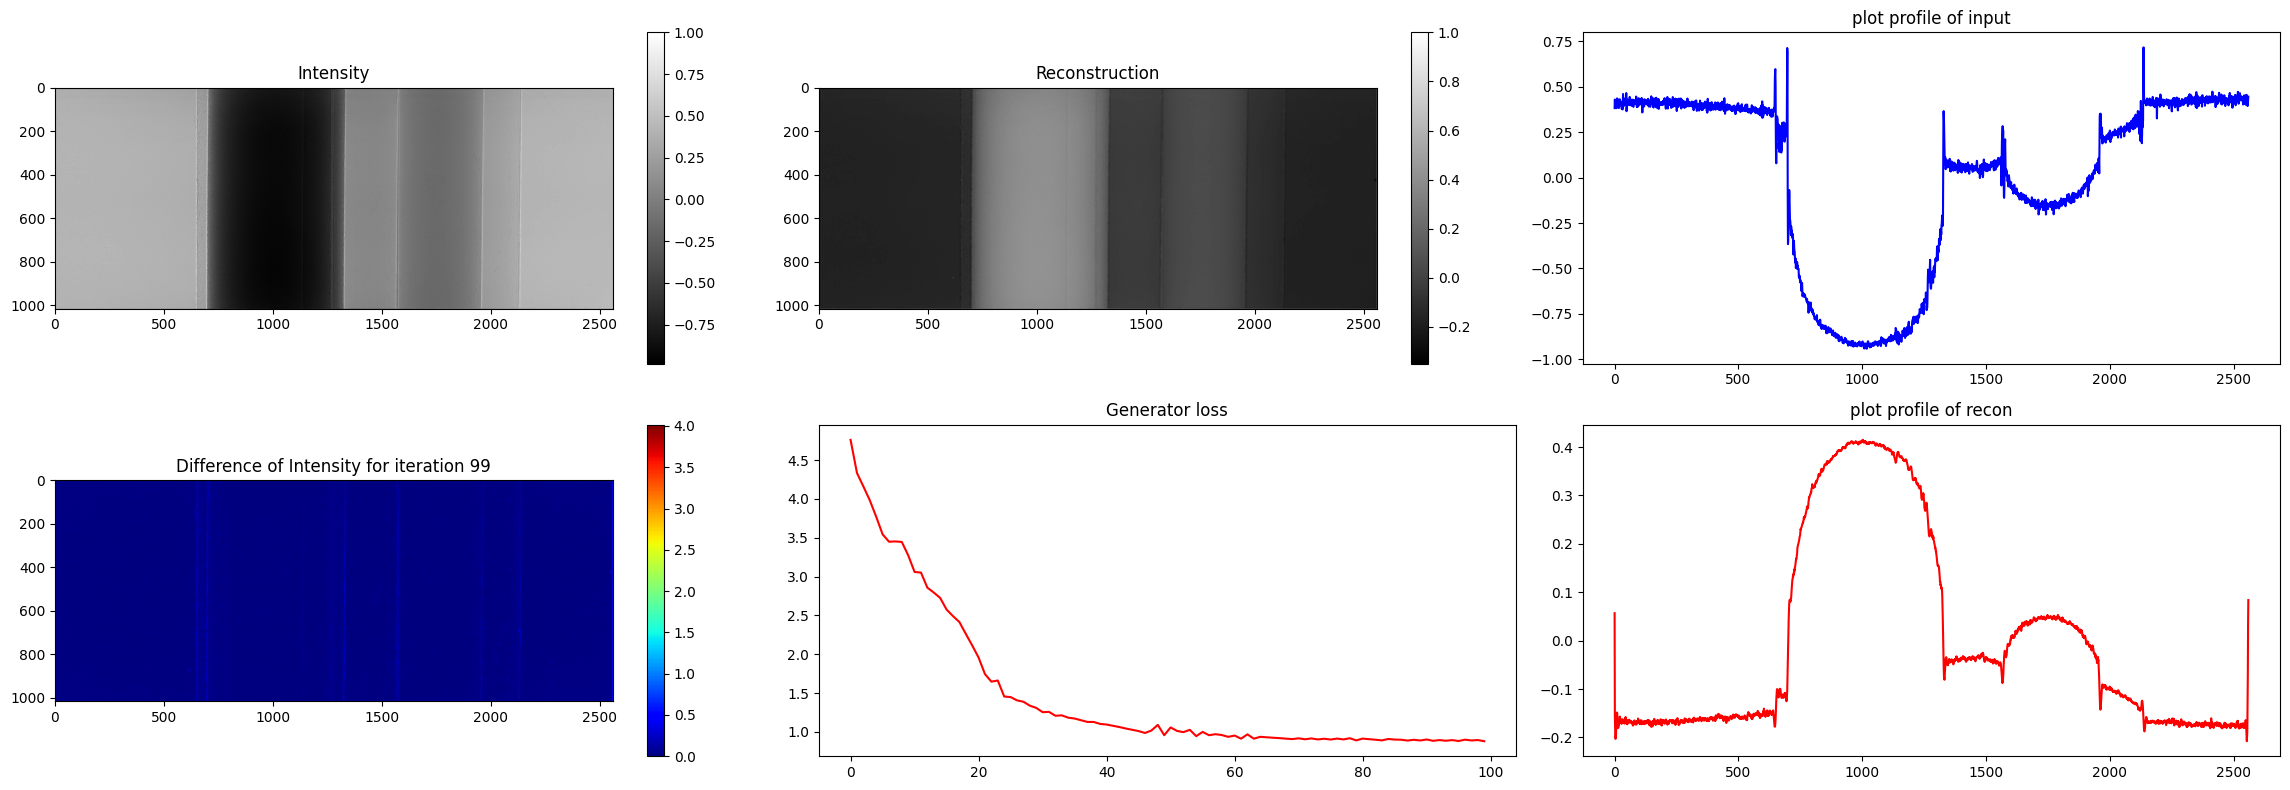

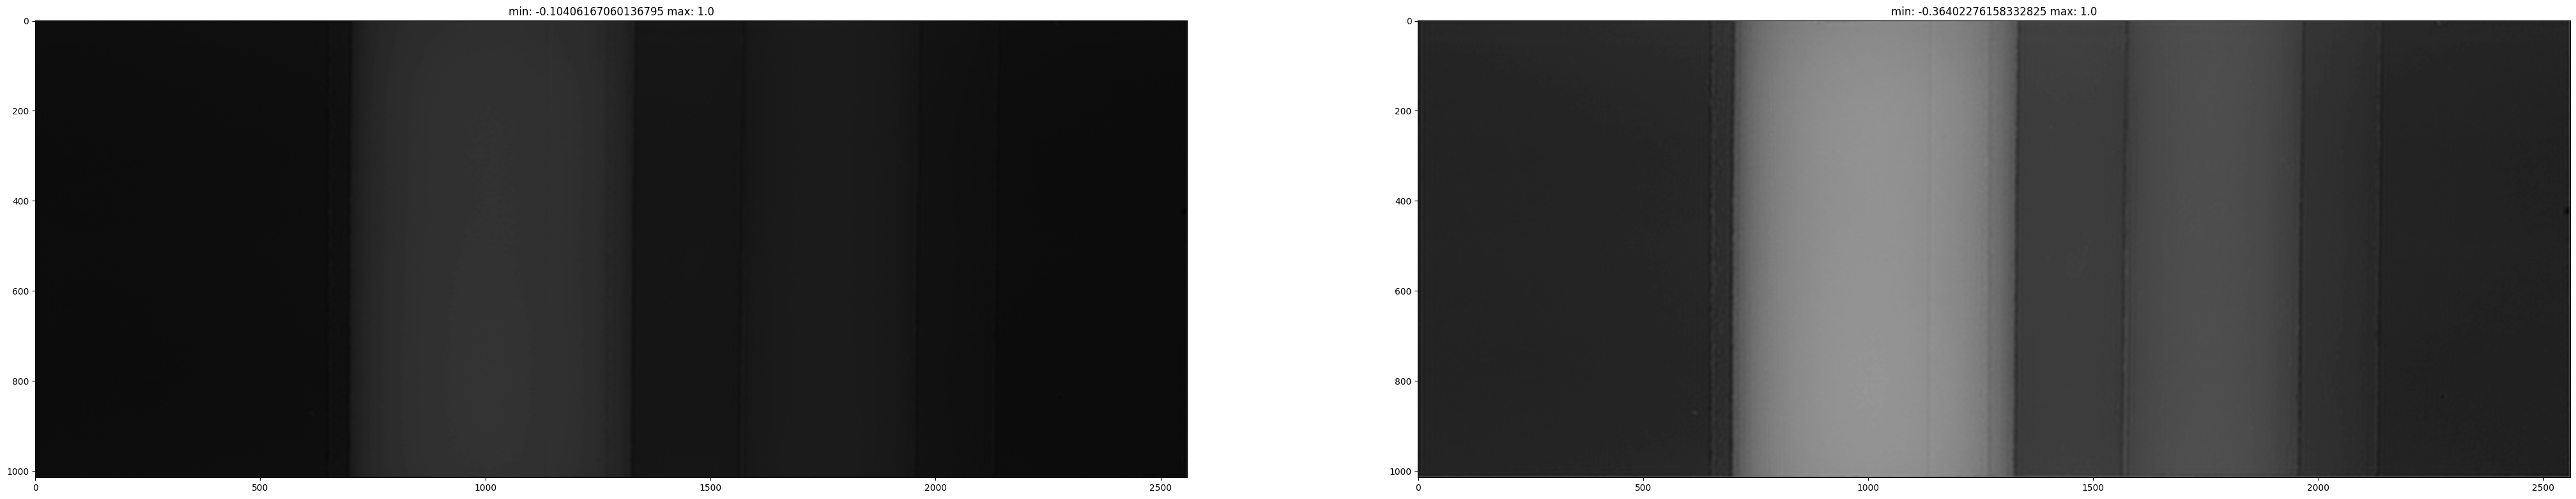

In [18]:
kwargs["i_input"] = data2
kwargs["init_model"] = True
kwargs['iter_num'] = 120
idx = 1500
image2 = get_all_info(path = path, idx = idx, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None)['image']
data2 = tfnor_phase(tf.reshape(image2, [1, px, py, 1]))[0,:,:,0]
gan_phase_object_phantom = GANphase(**kwargs)
start_time = time.time()
rec2 = gan_phase_object_phantom.recon
total_time = time.time() - start_time
print("Running time is {}".format(total_time))
visualize(rec2)

In [22]:

def ssim_check(image, rec_phantom):
    wave = tf.cast(tf.exp(tf.complex(-rec_phantom[0], rec_phantom[1])), dtype = tf.complex64)
    px, py = image.shape
    intensity = tfnor_phase(tf.reshape(tf.cast(tf.abs(tf.cast(tf.exp(tf.complex(-rec_phantom[0], rec_phantom[1])), dtype = tf.complex64))**2, dtype = tf.float32), [1, px, py, 1]))
    data_im = tfnor_phase(tf.reshape(image, [1, px, py, 1]))
    ssim = tf.image.ssim(data_im, intensity, max_val = 1.0)
 
    print("SSIM between the input image and the reconstructed image is {}".format(ssim))
    return ssim
ssim_check(data2, rec2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.40524897], dtype=float32)>

> ## <u> 2. For simulated data projected at z </u>

In [25]:

energy = 10
z = 0.5
pv = 5e-7
fname_data = '/home/hailudaw/hailudaw/ml_for_phase/propagations_2000/propagation_260.tif'
kwargs = get_all_info(images = [fname_data], idx = 0, energy_kev = energy, detector_pixel_size = pv, distance_sample_detector = z, alpha = 1e-8, delta_beta = 1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None)
px = kwargs['shape'][0]
py = kwargs['shape'][1]
data = tfnor_phase(tf.reshape(kwargs['image'], [1, px, py, 1]))[0,:,:,0]
kwargs["i_input"] = data
kwargs["z"] = kwargs["distance_sample_detector"]
kwargs["lam"] = kwargs["lam"]
kwargs["pv"] = kwargs["detector_pixel_size"]
kwargs["init_model"] = False
kwargs["save_wpath"] = None
print("******************************\n \tThe input is image with shape {}".format(kwargs['image'].shape), "at energy {} kev".format(energy), "with pixel size {} m".format(pv), "and distance {} m".format(z), "min/max of image" , np.min(kwargs['image']), np.max(kwargs['image']), "\n******************************")

In [ ]:
# energy = 10
# z = 0.5
# pv = 5e-7
# fname_data = '/home/hailudaw/hailudaw/ml_for_phase/propagations_2000/propagation_260.tif'
# input = io.imread(fname_data)
# px, py = input.shape

# data = tfnor_phase(tf.reshape(input, [1, input.shape[0], input.shape[1], 1]))[0, :, :, 0]
# visualizeput, data])
# kwargs = get_all_info(images = fname_data, idx = None, energy_kev = energy, detector_pixel_size = pv, distance_sample_detector = z, alpha = 1e-8, delta_beta = 1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None)

# gan_phase_object_sim = GANphase(data, energy, z, pv)
# start = time.time()
# rec_sim = gan_phase_object_sim.recon
# end = time.time()

# if 'save_path' in kwargs:
#     save_path = kwargs['save_path']
# else:
#     save_path = os.getcwd() + '/data/ganrec/recon/'

# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# if 'save_wpath' in kwargs:
#     save_wpath = kwargs['save_wpath']
# else:
#     kwargs['save_wpath'] = save_path

# file_name = 'simulated'
# print('Running time is {}'.format(end - start), 'saving to {}'.format(save_path))
# io.imsave(save_path + file_name+'_final_phase.tif', rec_sim[1], check_contrast=False)
# io.imsave(save_path + file_name+'_final_absorption.tif', rec_sim[0], check_contrast=False)
# visualize(rec_phantom)

2023-06-19 16:04:50.875652: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-06-19 16:04:50.893595: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 528.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-06-19 16:04:50.893633: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-06-19 16:04:51.047571: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) r

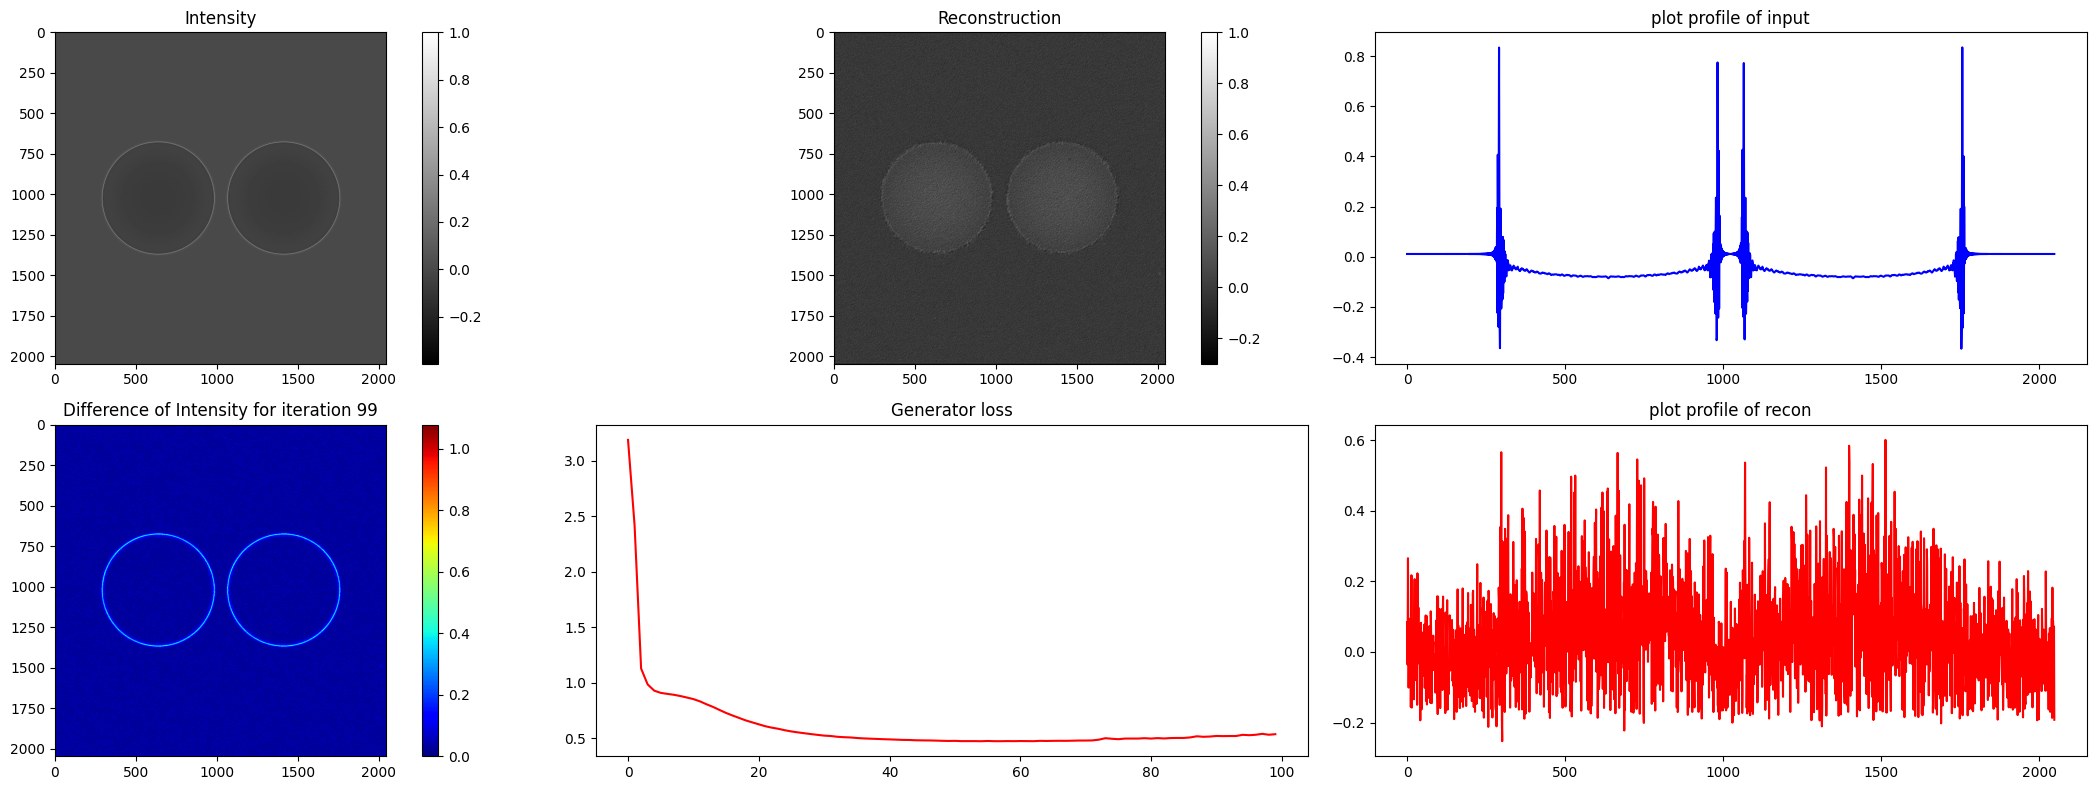

In [26]:
gan_phase_object_phantom = GANphase(**kwargs)
start_time = time.time()
rec2 = gan_phase_object_phantom.recon
total_time = time.time() - start_time
print("Running time is {}".format(total_time))


In [30]:
ssim_check(data, rec2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.95556855], dtype=float32)>

In [37]:
ff = fresnel_operator(gan_phase_object_phantom.px, gan_phase_object_phantom.py, gan_phase_object_phantom.pv, gan_phase_object_phantom.z, gan_phase_object_phantom.energy)
def ssim_check(image, rec_phantom, ff):
    propagated = FresnelPropagator(rec_phantom[1], rec_phantom[0], ff, z)
    data_im = tfnor_phase(tf.reshape(image, [1, px, py, 1]))
    ssim = tf.image.ssim(data_im, propagated, max_val = 1.0)
    visualize_interact([propagated[0,:,:,0], data_im[0,:,:,0]])
    print("SSIM between the input image and the reconstructed image is {}".format(ssim))
    return ssim
ssim_check(kwargs['image'], rec2, ff)

interactive(children=(Dropdown(description='Show or plot:', options=('show', 'plot'), value='show'), IntSlider…

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9556593], dtype=float32)>

In [36]:
def peak_signal_to_noise(image, rec_phantom, ff, z):
    propagated = FresnelPropagator(rec_phantom[1], rec_phantom[0], ff, z)
    data_im = tfnor_phase(tf.reshape(image, [1, px, py, 1]))
    ssim = tf.image.ssim(data_im, propagated, max_val = 1.0)
    # visualize_interact([propagated[0,:,:,0], data_im[0,:,:,0]])
    psnr = tf.image.psnr(data_im, propagated, max_val = 1.0)
    print("Noise to signal ratio is {}".format(psnr))
    return psnr
peak_signal_to_noise(kwargs['image'], rec2, ff, kwargs['distance'])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([28.46919], dtype=float32)>

### <u> Prevous attemps </u>

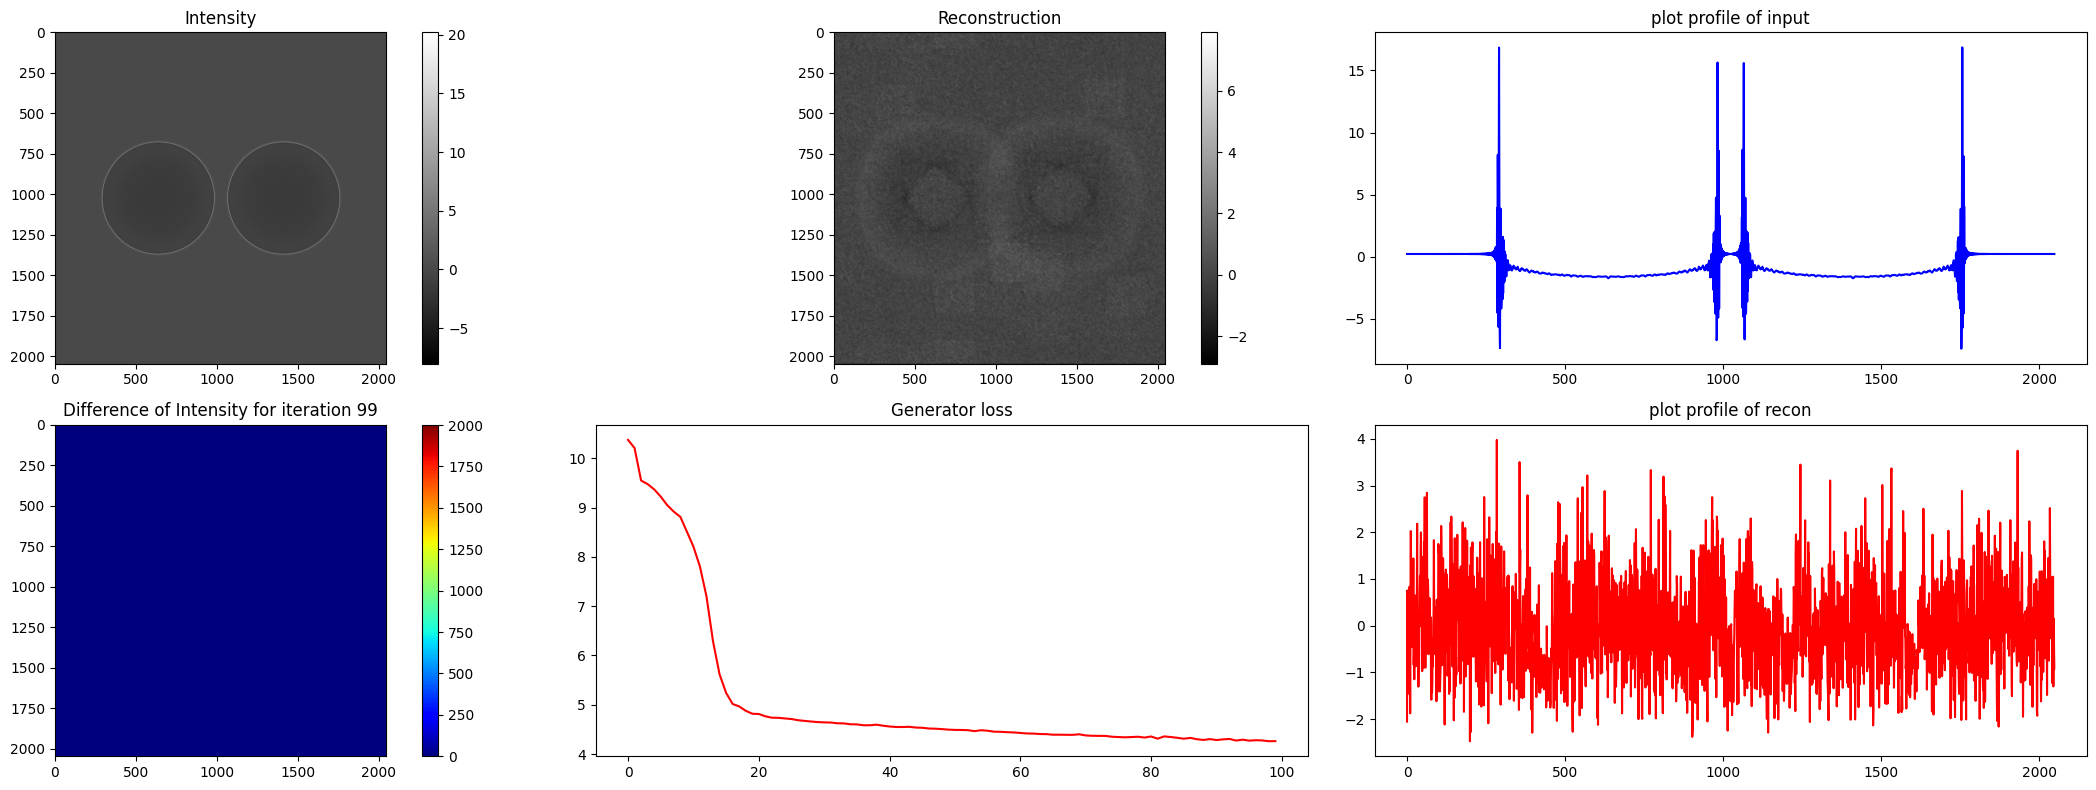

In [ ]:
gan_phase_object = GANphase(**kwargs)
start = time.time()
rec = gan_phase_object.recon
end = time.time()

print('Running time is {}'.format(end - start))
io.imsave(save_path + 'sim_phase_2.tif', rec[1], check_contrast=False)
io.imsave(save_path + 'sim_absorption_2.tif', rec[0], check_contrast=False)


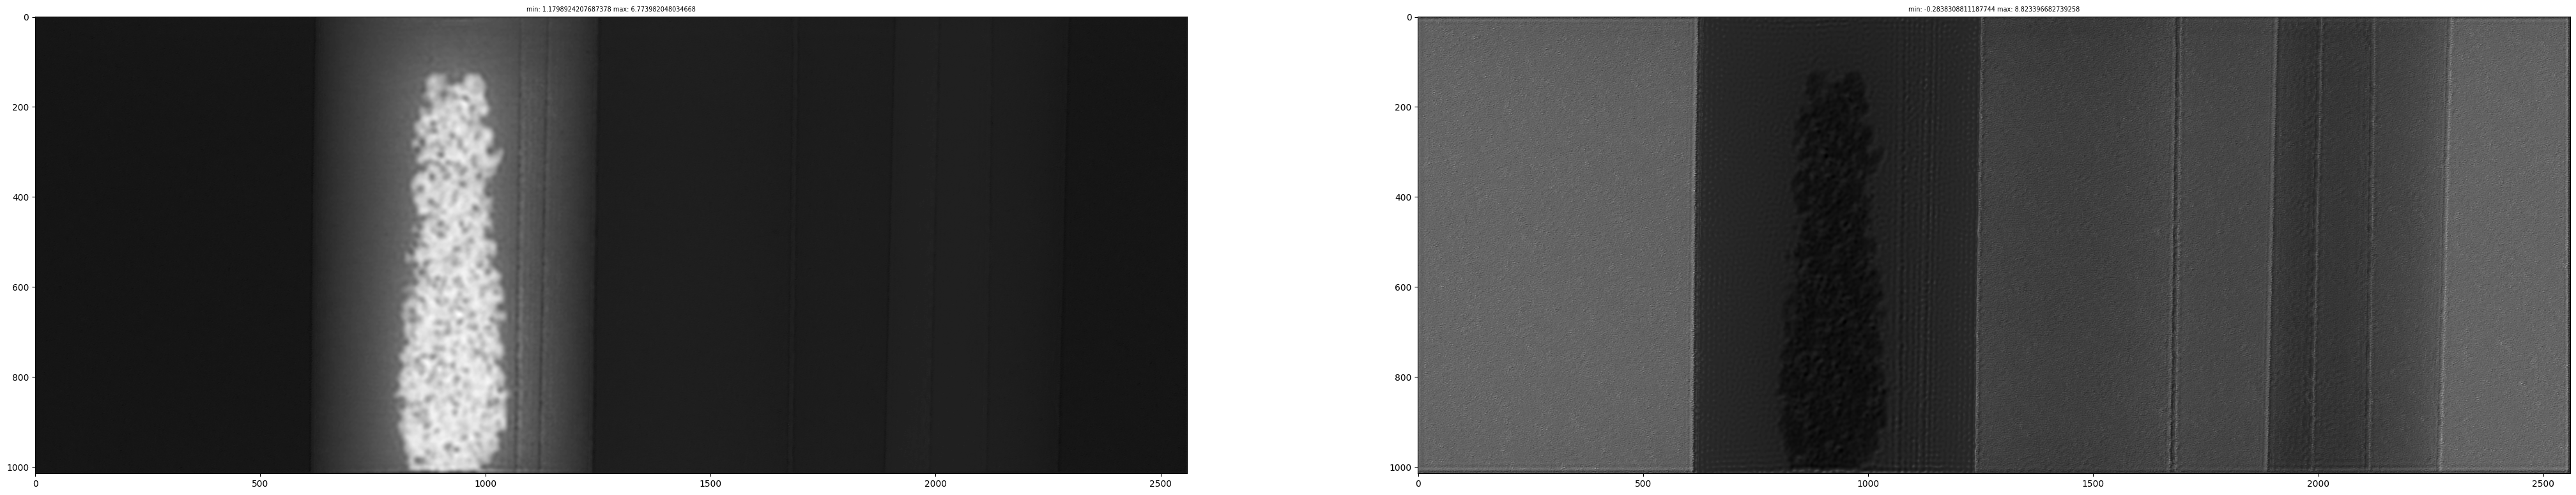

In [65]:
visualize